In [11]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
from pathlib import Path
files = list(Path(BREPNET_NPZ_DIR).glob("*.npz"))

feats = np.load(files[0], allow_pickle=True)

for k, v in feats.items():
    print(k, v.shape)

face_features (9, 7)
face_point_grids (9, 7, 10, 10)
edge_features (16, 10)
coedge_point_grids (31, 12, 10)
coedge_features (31, 1)
coedge_lcs (31, 4, 4)
coedge_scale_factors (31,)
coedge_reverse_flags (31,)
next (31,)
mate (31,)
face (31,)
edge (31,)


In [13]:
from src.modeling.ssl_graph_brep.data_module.brep_dataset import BRepNPZDataset

dataset = BRepNPZDataset(BREPNET_NPZ_DIR)
print(f"Dataset length: {len(dataset)}")
g = dataset.get(0)
print(g)

for k, v in g.items():
    print(k, v.shape if hasattr(v, "shape") else v)

Dataset length: 129
HeteroData(
  face={
    x=[9, 7],
    uv=[9, 7, 10, 10],
    num_nodes=9,
  },
  edge={
    x=[16, 10],
    num_nodes=16,
  },
  coedge={
    x=[31, 1],
    grid=[31, 12, 10],
    lcs=[31, 4, 4],
    scale=[31],
    reverse=[31],
    num_nodes=31,
  },
  (coedge, next, coedge)={ edge_index=[2, 31] },
  (coedge, mate, coedge)={ edge_index=[2, 31] },
  (coedge, to_face, face)={ edge_index=[2, 31] },
  (coedge, to_edge, edge)={ edge_index=[2, 31] }
)


In [15]:
from src.modeling.ssl_graph_brep.data_module.brep_data_loader import BRepDataModule
data_module = BRepDataModule(BREPNET_NPZ_DIR, batch_size=32, num_workers=0)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
print(batch)

HeteroDataBatch(
  face={
    x=[2057, 7],
    uv=[2057, 7, 10, 10],
    num_nodes=2057,
    batch=[2057],
    ptr=[33],
  },
  edge={
    x=[5574, 10],
    num_nodes=5574,
    batch=[5574],
    ptr=[33],
  },
  coedge={
    x=[11117, 1],
    grid=[11117, 12, 10],
    lcs=[11117, 4, 4],
    scale=[11117],
    reverse=[11117],
    num_nodes=11117,
    batch=[11117],
    ptr=[33],
  },
  (coedge, next, coedge)={ edge_index=[2, 11117] },
  (coedge, mate, coedge)={ edge_index=[2, 11117] },
  (coedge, to_face, face)={ edge_index=[2, 11117] },
  (coedge, to_edge, edge)={ edge_index=[2, 11117] }
)


In [16]:
from src.modeling.ssl_graph_brep import train


train.run(
    npz_brep_dir=BREPNET_NPZ_DIR,
    batch_size=32,
    epochs=10,
    num_workers=0,
    proj_dim=128,
    lr=1e-3,
    hidden=64,
    tau=0.1,
    lambda_topo_next=1.5,
    lambda_topo_mate=1.5,
    aug_p=0.15,
    topo_tau=0.07,
    weight_decay=1e-4,
    validation_ratio=0.2,
    test_ratio=0.1,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:701: Checkpoint directory D:\workspace\projects\freelance\Fusion3DNet\models\ssl_brep exists and is not empty.

  | Name        | Type                | Params | Mode 
------------------------------------------------------------
0 | face_enc    | UVNetSurfaceEncoder | 390 K  | train
1 | coedge_enc  | UVNetCurveEncoder   | 142 K  | train
2 | edge_lin    | Linear              | 704    | train
3 | gnn         | BRepHeteroGNN       | 25.5 K | train
4 | projector   | Sequential          | 33.0 K | train
5 | scorer_next | BilinearScorer      | 16.4 K | train
6 | scorer_mate | BilinearScorer      | 16.4 K | train
------------------------------------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.499     Total estimated model param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


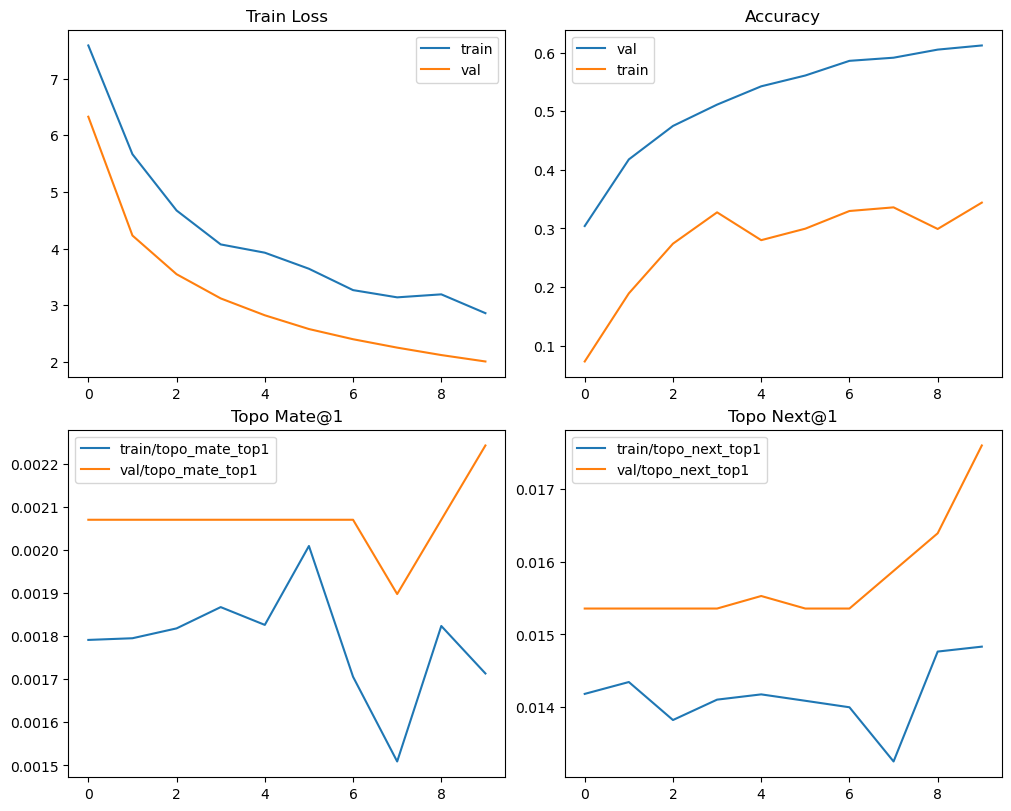

In [17]:
from src.modeling.ssl_graph_brep import plots

metrics_csv = REPORTS_DIR / "ssl_brep" / "version_36" / "metrics.csv"

plots.plot_training_curves(metrics_csv)

In [18]:
from src.modeling.ssl_graph_brep.inference import extract_embeddings, topk_similar, search_by_name

ckpt = MODELS_DIR / "ssl_brep" / "ssl-brep-epoch=09-val_infoNCE_acc=0.612.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "42. Ejector"
data_dir = Path(BREPNET_NPZ_DIR)
ids, E = extract_embeddings(ckpt, data_dir)

topk_idx = topk_similar(E, k=10)
for i, nn_idx in enumerate(topk_idx[:15]):
    print("Query:", ids[i])
    print("Top-10:", [ids[j] for j in nn_idx])
    print("---")

Query: 42. Ejector-01.prt
Top-10: ['42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-02', '42. Ejector-07.prt', '42. Ejector-08.prt', '42. Ejector-04.prt', '42. Ejector-09.prt', '42. Ejector-03.prt']
---
Query: 42. Ejector-02
Top-10: ['42. Ejector-02', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-03.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-04.prt', '42. Ejector-07.prt', '42. Ejector-08.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-03.prt
Top-10: ['42. Ejector-03.prt', '42. Ejector-02', '42. Ejector-04.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-09.prt', '42. Ejector-10.prt', '42. Ejector-06.prt', '44. Extractor Pin-10.prt', '44. Extractor Pin-09.prt']
---
Query: 42. Ejector-04.prt
Top-10: ['42. Ejector-04.prt', '42. Ejector-03.prt', '42. Ejector-09.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-10.prt', '42. Ejector-02', 'Зацеп трубки направляющий

In [24]:
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "Затвор"

ids, E = extract_embeddings(model_ckpt=ckpt, data_dir=BREPNET_NPZ_DIR)


results = search_by_name(ids, E, query_name="Защелка АК 2.prt", include_self=True, max_print=30)


Запрос: Защелка АК 2.prt
   1. 100.00%  Защелка АК 2.prt
   2.  99.54%  Защелка АК 1.prt
   3.  99.53%  Защелка АК.prt
   4.  99.42%  Защелка АК 3.prt
   5.  98.86%  Защелка АК 4.prt
   6.  98.77%  Кожух 8.prt
   7.  98.76%  Кожух 6.prt
   8.  98.74%  Кожух 7.prt
   9.  98.72%  Кожух 9.prt
  10.  98.68%  Кожух 10.prt
  11.  98.66%  Защелка АК 9.prt
  12.  98.64%  Защелка АК 5.prt
  13.  98.55%  Защелка АК 6.prt
  14.  98.51%  Колодка прицельная 5.prt
  15.  98.50%  Защелка АК 7.prt
  16.  98.45%  Колодка прицельная 3.prt
  17.  98.45%  Колодка прицельная 4.prt
  18.  98.44%  Колодка прицельная 1.prt
  19.  98.40%  Колодка прицельная.prt
  20.  98.37%  43. Extractor-07.prt
  21.  98.37%  Колодка прицельная 6.prt
  22.  98.36%  Кожух.prt
  23.  98.35%  Защелка.prt
  24.  98.31%  43. Extractor.prt
  25.  98.31%  Защелка 1.prt
  26.  98.30%  Защелка 4.prt
  27.  98.30%  43. Extractor-01.prt
  28.  98.30%  43. Extractor-02.prt
  29.  98.30%  Защелка 5.prt
  30.  98.29%  Защелка 6.prt
